# Where to stay in Beijing ?
## A data-driven approach to choose the most value listing in Beijing AirBnb.
---
## Table of Content
1. [Problem Understanding](#problem_understanding)
2. [Data Understanding](#data_understanding)
3. [Data Preprocessing](#data_preprocessing) 
4. [Exploratory Data Analysis](#eda)
5. [Data Preparation for modelling](#data_preparation) 
6. [Machine Learning Modeling](#modelling)
7. [Evaluation](#evaluation)
8. [Conclusion](#conclusion)

Available in my Github [here](https://github.com/jeffrisandy/beijing_airbnb)

The main findings of the code can be found at the post available [here](https://medium.com/@jeffrisandy/where-to-stay-in-beijing-airbnb-795bb184acd7).

___

## 1. Problem Understanding <a name="problem_understanding"></a>

If you have limited budget, price would be the biggest factor to decide where to stay. However, there are many factors that can affect the price such as location, host rating score, property type, room size, amenities, and others. Some people decides to choose by locations. But often, the better locations is, the higher price would be. But, is it worth? Probably not. Instead, we should look ways to maximising the value for the price we pay. The problem remains, **where would we stay for the value ?**

Therefore, I used AirBnb Beijing listings data from 2016 to try to take a look closer in finding the most value stay, specifically:

1. [Where is the most value neighbourhood ?](#question_1)
2. [Where is the most positive vibes neighbourhood ?](#question_2)
3. [How to choose and evaluate listings for the most value for price ?](#question_3)




---
## 2. Data Understanding <a name="data_understanding"></a>

### 2.1 Import required library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from textblob import TextBlob

import nltk
nltk.download('stopwords')

#polyglot for languange detection
from polyglot.detect import Detector

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffsan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.2 Load the data

In [4]:
#Load data
listings = pd.read_csv('data/beijing/listings.csv', low_memory=False)
reviews = pd.read_csv('data/beijing/reviews.csv', low_memory=False)


### 2.3 - A look at the `listings` data

In [128]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,44054,https://www.airbnb.com/rooms/44054,20180818222531,2018-08-18,Modern 3BD/2BTH (4Beds) Serviced Apt (A39),East Apartments offers comfortable living away...,East Apartments is a western managed serviced ...,East Apartments offers comfortable living away...,none,The neighborhood is a private compound. Just ...,"*For long term reservations (over 90 days), pl...",The easiest method to get around is by taxi or...,*Guests have access to the Fulicheng gardens,NaN,Registration All guests are required to have a...,NaN,NaN,https://a0.muscache.com/im/pictures/248048/ff9...,NaN,192875,https://www.airbnb.com/users/show/192875,East Apartments,2010-08-06,"Beijing, Beijing, China",Hi everyone! My name is Sev. I'm the Owner/O...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/9ea49dd1-d...,https://a0.muscache.com/im/pictures/9ea49dd1-d...,Shuangjing,12,12,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Beijing, Beijing, China",Shuangjing,朝阳区 / Chaoyang,NaN,Beijing,Beijing,100022,Beijing,"Beijing, China",CN,China,39.895030,116.451635,t,Serviced apartment,Entire home/apt,9,2.0,3.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1464.0,$814.00,"$8,157.00","$26,892.00",$690.00,$69.00,7,$69.00,1,365,2 days ago,t,17,37,64,332,2018-08-18,79,2010-08-25,2018-08-02,92.0,9.0,9.0,10.0,9.0,9.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,12,0.81
1,100213,https://www.airbnb.com/rooms/100213,20180818222531,2018-08-18,The Great Wall Box Deluxe Suite A团园长城小院东院套房,This is your guide to live by the Great Wall! ...,This is your guide to live by the Great Wall! ...,This is your guide to live by the Great Wall! ...,none,"5 mins walk to Panglongshan Great Wall, 25 min...",这里地处山区，森林覆盖率高，几乎没有PM2.5的影响。但早晚温差大，尤其晚间气温较北京市区低...,We arrange taxi service at a very reasonable p...,NaN,NaN,"1, we have some kittens, thus it may not be su...",NaN,NaN,https://a0.muscache.com/im/pictures/85ad3843-0...,NaN,527062,https://www.airbnb.com/users/show/527062,Joe,2011-04-22,"Beijing, Beijing, China",我是老乔，喜欢长城，喜欢简单的生活。\r\n2011年，我开始移居到北京东北部的古北口村，潮...,a few days or more,0%,NaN,f,https://a0.muscache.com/im/pictures/9699cf5e-a...,https://a0.muscache.com/im/pictures/9699cf5e-a...,NaN,4,4,"['phone', 'facebook', 'reviews']",t,f,"Beijing, Beijing, China",NaN,密云县 / Miyun,NaN,Beijing,Beijing,101508,Other (International),"Beijing, China",CN,China,40.684340,117.172313,t,Guest suite,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",""Free parkin...",NaN,"$1,200.00","$7,200.00","$28,800.00",$0.00,$0.00,1,$0.00,1,

In [21]:
print("Listings data have {} rows and {} columns".format(listings.shape[0], listings.shape[1]))


Listings data have 18881 rows and 96 columns


In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18881 entries, 0 to 18880
Data columns (total 96 columns):
id                                  18881 non-null int64
listing_url                         18881 non-null object
scrape_id                           18881 non-null int64
last_scraped                        18881 non-null object
name                                18880 non-null object
summary                             17940 non-null object
space                               12173 non-null object
description                         18109 non-null object
experiences_offered                 18881 non-null object
neighborhood_overview               11006 non-null object
notes                               8507 non-null object
transit                             11121 non-null object
access                              10144 non-null object
interaction                         9736 non-null object
house_rules                         8831 non-null object
thumbnail_url             

In [17]:
#Categorical columns 
listings.select_dtypes(include=[object]).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'has_availability', 'calendar_last_scraped', 'first_review',
       'last_review', 'requires_license', 'jurisdictio

In [18]:
# Numeric columns 
listings.select_dtypes(include=[np.number]).columns

Index(['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'xl_picture_url',
       'host_id', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [14]:
listings.isnull().sum().sort_values(ascending=False)

xl_picture_url                      18881
neighbourhood_group_cleansed        18881
host_acceptance_rate                18881
license                             18881
thumbnail_url                       18881
medium_url                          18881
jurisdiction_names                  18880
square_feet                         18860
weekly_price                        18434
monthly_price                       18431
security_deposit                    11695
cleaning_fee                        11144
notes                               10374
house_rules                         10050
host_neighbourhood                   9414
interaction                          9145
access                               8737
review_scores_value                  7985
review_scores_location               7984
review_scores_checkin                7968
review_scores_rating                 7961
review_scores_communication          7960
review_scores_accuracy               7958
review_scores_cleanliness         

In [20]:
# columns that have 50% more missing values
listings.columns[listings.isnull().sum() > 0.5 * listings.shape[0]]

Index(['notes', 'house_rules', 'thumbnail_url', 'medium_url', 'xl_picture_url',
       'host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'license', 'jurisdiction_names'],
      dtype='object')

**First look at the listings data :** 
- 14 columns have missing values more than 50% of total data, All will be dropped.
- Column `price`, `cleaning_fee`, and `extra_people` requires encoding, they have `$` sign. And other price related columns such as `weekly_price`, `monthly_price`, `security_deposit` will be as is as they will not be used as they have more than 50% missing values
- Column `neigbourhood_cleansed` requires translation to english. And some text in column `space` and `description` are also not in english, however I decided to let it as it because they are not related to the first two questions 
- Columns `host_response_rate` also requires encoding, they have `%` and need to be removed.

### 2.4 - A look at the `reviews` data

In [22]:
print("Reviews data have {} rows and {} columns".format(reviews.shape[0], reviews.shape[1]))

Reviews data have 129352 rows and 6 columns


In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129352 entries, 0 to 129351
Data columns (total 6 columns):
listing_id       129352 non-null int64
id               129352 non-null int64
date             129352 non-null object
reviewer_id      129352 non-null int64
reviewer_name    129349 non-null object
comments         128875 non-null object
dtypes: int64(3), object(3)
memory usage: 5.9+ MB


In [24]:
reviews.head(100)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...
3,44054,1118657,2012-04-12,1787536,Andreyna,"Sev was incredibly helpful, showed us around t..."
4,44054,2140650,2012-08-30,1179565,Frances,The appartment was ideal for our party of 6 ad...
5,44054,2439478,2012-09-28,2328151,Ricardo,Nice place to stay when travelling in a group ...
6,44054,2507676,2012-10-04,3659992,Patrick,We had a great experience in Beijing. The apa...
7,44054,2886867,2012-11-15,3725353,Zahra,The apartment was exactly what I expected (as ...
8,44054,3722573,2013-03-08,1988718,Petar,Definitely the place to stay when in Beijing. ...
9,44054,4447534,2013-05-06,2824806,Emil,We had a great time staying at Sev's apparteme...


In [51]:
#missing values
reviews.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      3
comments         477
dtype: int64

In [58]:
reviews.groupby(pd.to_datetime(reviews.date).dt.year).count()['comments']

date
2010        2
2011       23
2012       96
2013      342
2014      904
2015     3171
2016    14652
2017    48954
2018    60731
Name: comments, dtype: int64

**First look at the `reviews` data :** 
- Column `commnets` have 477 missing values and have mixed languange.
- Column `date` requires conversion to datetime 
- Only use reviews data from 2016
- Only use english language in `comments` 


---
## 3. Data Preprocessing  <a name="data_preprocessing"></a>

### 3.1 Data preprocessing for `listings`

In [136]:
def listings_preprocessing(df):
    """
    The function will translate neigbourhood_cleansed to english, it requires internet connection.
    And it will remove "$" in price and convert to float, and also drop columns that have more than 50% 
    missing values

    """
    #remove columns that have 50% and more missing values
    to_drop = listings.columns[listings.isnull().sum() > 0.5 * listings.shape[0]]
    df = df.drop(columns=to_drop)
    
    # Translate neigbourhood_cleansed to english
    nb = df.neighbourhood_cleansed.value_counts().index
    translate = {}
    for word in nb:
        try:
            chinese_blob = TextBlob(word)
            translate[word] = chinese_blob.translate(from_lang="zh-CN", to='en').words[0]
            print(translate[word])
        except:
            #error when tranlating 通州区 , so manual translating
            translate['通州区 / Tongzhou'] = 'Tongzhou'
            print('Tongzhou')
            
    #replace neighbourhood_cleansed based on translate dictionary
    df['neighbourhood_cleansed'] =  df.neighbourhood_cleansed.replace(translate)

    #encode price column, remove "$" & ","
    df.price = df.price.apply(lambda x: float(x.strip("$").replace(",","") if not pd.isnull(x) else np.nan))
    df.host_response_rate = df.host_response_rate.apply(lambda x: float(x.strip("%") if not pd.isnull(x) else np.nan))
    
    return df

In [137]:
#preprocess listings df
listings_en = listings_preprocessing(listings)

Chaoyang
Haidian
Dongcheng
Xicheng
Fengtai
Tongzhou
Changping
Miyun
Huairou
Daxing
Yanqing
Shunyi
Fangshan
Shijingshan
Pinggu
Mentougou


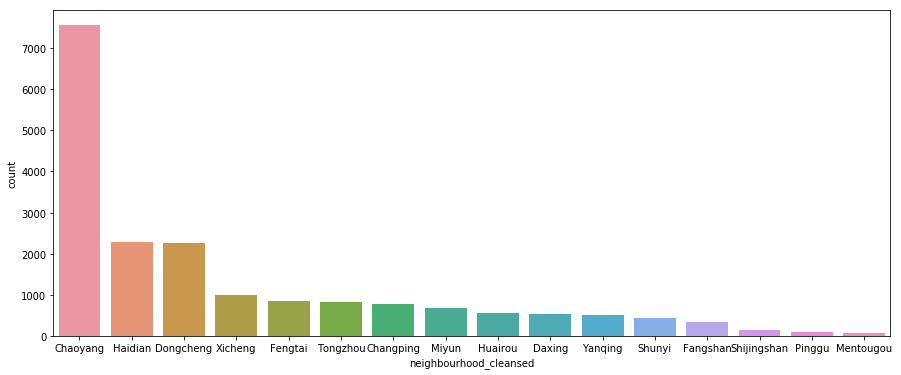

In [82]:
#plotting how many reviews available per neighbourhood_cleansed
f, ax = plt.subplots(figsize=(15,6) )
order = listings_en.groupby('neighbourhood_cleansed').count().sort_values( 'id', ascending=False).index
sns.countplot('neighbourhood_cleansed', data=listings_en, ax=ax, order=order)

### 3.2 Data preprocessing for `reviews`

In [69]:
""" Preprocessing reviews dataframe"""

def detect_lang(sentences):
    """using polyglot to detect language"""
    try:
        #return blob.words[0].detect_language()
        detector = Detector(sentences)
        return detector.language.code
    except:
        return np.nan

def reviews_preprocessing(review_df, listing_df):
    """
    The function will take only reviews later than 2016, and use detect_lang function to detect language.
    And columns 'neighbourhood_cleansed' will be added to review_df
    Return review_df with english languange ('en')
    """
    from polyglot.detect import Detector
    
    #drop missing comments
    review_df = review_df.dropna()

    #convert col 'date' to datetime
    review_df.date = pd.to_datetime(review_df.date)

    #use only data from 2016
    review_df = review_df[review_df.date > '2016']

    #detect = english language   
    review_df['lang'] = review_df.comments.apply(detect_lang)
    
    #creating dictionary that mapping listing_id to neigbourhood_cleansed
    id_to_nb = {}
    for list_id, nb in listing_df[['id', 'neighbourhood_cleansed']].values:
        id_to_nb[list_id] = nb  
        
    #add neighbourhood_cleansed to reviews df
    review_df['neighbourhood_cleansed'] = review_df.listing_id.map(id_to_nb)
    
    return review_df[review_df.lang == 'en']

In [70]:
reviews_en = reviews_preprocessing(reviews, listings_en)

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

In [73]:
reviews_en.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,neighbourhood_cleansed
33,44054,61908408,2016-02-09,35700614,Veda,Nice and clean apartment with everything we ne...,en,Chaoyang
34,44054,62810127,2016-02-17,52866028,Feynman,The apartment is lovely and spacious. The loca...,en,Chaoyang
37,44054,74537334,2016-05-15,58543169,Ross,Arrival: we contacted 4 different people to ar...,en,Chaoyang
38,44054,86220595,2016-07-15,80273021,Madhavi,The host canceled this reservation 3 days befo...,en,Chaoyang
44,44054,109657824,2016-10-22,65428411,Llewell,great host and apartment. The apartment is wel...,en,Chaoyang


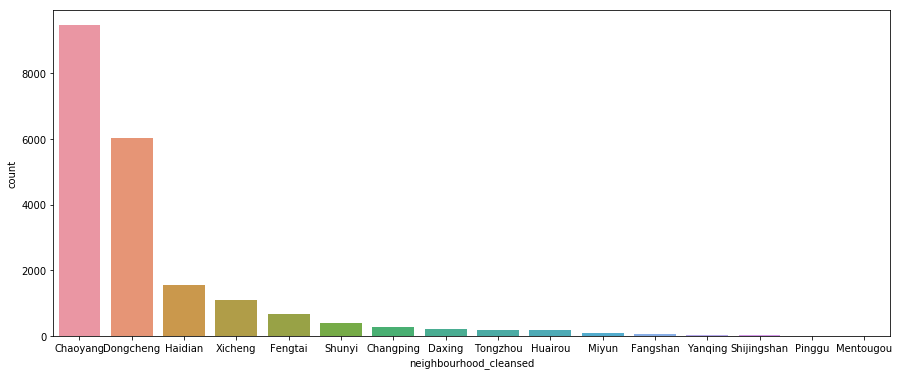

In [74]:
#plotting how many reviews available per neighbourhood_cleansed
f, ax = plt.subplots(figsize=(15,6) )
order = reviews_en.groupby('neighbourhood_cleansed').count().sort_values( 'listing_id', ascending=False).index
sns.countplot('neighbourhood_cleansed', data=reviews_en, ax=ax, order=order)

In [75]:
reviews_en.groupby('neighbourhood_cleansed')['listing_id'].count().sort_values( ascending=False)

neighbourhood_cleansed
Chaoyang       9457
Dongcheng      6028
Haidian        1557
Xicheng        1080
Fengtai         678
Shunyi          400
Changping       273
Daxing          201
Tongzhou        189
Huairou         185
Miyun            95
Fangshan         66
Yanqing          40
Shijingshan      33
Pinggu            9
Mentougou         8
Name: listing_id, dtype: int64

#### Notes
There are lack of review data in `['Miyun', 'Fangshan', 'Yanqing', 'Shijingshan','Pinggu', 'Mentougou']` neigbourhood. I decided to exclude those neighbourhood in `reviews_en` and `listings_en`


In [138]:
#exclude lack of data neigbourhood
nb_out = ['Miyun', 'Fangshan', 'Yanqing', 'Shijingshan','Pinggu', 'Mentougou']
reviews_en = reviews_en[~reviews_en.neighbourhood_cleansed.isin(nb_out)]
listings_en = listings_en[~listings_en.neighbourhood_cleansed.isin(nb_out)]

print("preprocessing listings_en data have {} rows and {} columns".format(listings_en.shape[0], listings_en.shape[1]))
print("Preprocessing reviews_en data have {} rows and {} columns".format(reviews_en.shape[0], reviews_en.shape[1]))

preprocessing listings_en data have 17041 rows and 82 columns
Preprocessing reviews_en data have 20048 rows and 8 columns


### 3.3 Preprocessing for sentiment polarity with TextBlob

In [84]:
def reviews_compile(reviews, listings) :
    """
    Compile reviews text data per sentences and calculate sentiment polarity using textblob.
    
    Return a nested dictionary :
        neighbourhood
            'pos_sentences' : list of positive sentences
            'neg_sentences' : List of negative sentences
            'all_sentences' : list of all sentences (both positive and negative)
            'pos'           : total count of positive sentences
            'neg'           : total count of negative sentences
            'pos_neg'       : ratio total count of positive to negative sentences
    
    """
    
    from collections import defaultdict
    from tqdm import tqdm

    reviews_compile = defaultdict(lambda: defaultdict(dict))

    for nb in tqdm(listings.neighbourhood_cleansed.unique()):

        pos = 0
        neg = 0
        pos_sentences = []
        neg_sentences = []
        all_sentences = []
        for list_id in listings[listings.neighbourhood_cleansed == nb]['id'].unique():
            comments = ".".join(reviews[reviews.listing_id == list_id]['comments'])
            blob = TextBlob(comments)

            for sentence in blob.sentences:
                #using cutt off = 0.1 for positive sentiment & -0.1 for negative sentiment
                try :
                    if (sentence.sentiment.polarity > 0.1) and (detect_lang(str(sentence)) == 'en')  :
                        pos += 1
                        pos_sentences.append(str(sentence))
                        all_sentences.append(str(sentence))

                    elif (sentence.sentiment.polarity < -0.2) and (detect_lang(str(sentence)) == 'en')   :
                        neg += 1
                        neg_sentences.append(str(sentence))
                        all_sentences.append(str(sentence))
                except:
                    continue

        reviews_compile[nb]['pos_sentences'] =  pos_sentences
        reviews_compile[nb]['neg_sentences'] =  neg_sentences
        reviews_compile[nb]['all_sentences'] =  all_sentences
        reviews_compile[nb]['pos'] =  pos
        reviews_compile[nb]['neg'] =  neg
        reviews_compile[nb]['pos_neg'] =  pos / (neg+1)
    
    return reviews_compile

In [100]:
#compile for sentiment polarity
reviews_en_compile = reviews_compile(reviews_en, listings_en)

  0%|          | 0/10 [00:00<?, ?it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

 80%|████████  | 8/10 [01:50<00:27, 13.86s/it]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
 90%|█████████ | 9/10 [01:53<00:12, 

In [87]:
reviews_en_compile['Huairou']['pos_sentences'][:10]

["A must stay if you're visiting the Mutianyu Great Wall.",
 'Not only is this a great place to stay, it is what our DREAM home would be hands down.',
 'Beautiful space, bright open kitchen/dining space, super comfortable bed.',
 'Then get a 15min Taxi to visit the Great Wall.',
 'Make sure to bring some supplies to cook your own food.',
 'We live in Beijing so just wanted to escape , and this place was perfect for that!',
 'Jimmy has amazing taste , the decor , furniture and even his books reflected on The owners personality.',
 'We took our 2.5 year old baby and parents , baby slept of the Japanese bed on the floor , very comfortable .',
 "If you want a unique experience, stay at Andrew's bungalow at the base of the Great Wall at Jian Kou.",
 'If you are English speaking, Andrew is a great help because he is fluent in English.']

In [88]:
reviews_en_compile['Huairou']['neg_sentences'][:10]

["That's not very good.",
 'Big lounge area in case of bad weather, with projector.',
 'One of our members got sick and the host provided medicine for us.',
 'The house is typical northern country style including a small veggie garden.',
 'We were there with babies in beginning of April and it was a bit cold in the hotel but Michael helped us putting on heater.',
 'If you are looking for an out of the ordinary experience with a touch of nature this is what you need.',
 "And because it's in the mountains, you may want to bring mosquito sprays and all kinds of insect repellent if you want to go there in summer like what I did.",
 'The walk to the wall in the guide book requires quite a bit of climbing and is not suitable for everyone.',
 'It was also very hard to find!',
 'A little pity that the smell in the main bathroom was a little annoying, hope the owner could do something about it..The host canceled this reservation 8 days before arrival.']

**Notes**:
It seems that some neg_sentences should be actually positive. It was accuracy issue with the TextBlob sentiment polarity. However, in general it is still useful to use TextBlob sentiment polarity

---
## 4. Exploratory Data Analysis <a name="eda"></a>

**Correlation**

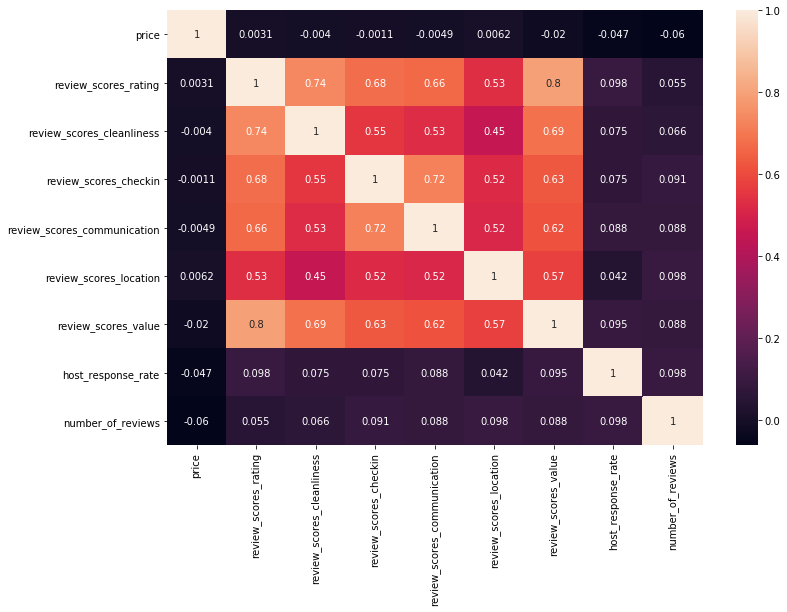

In [256]:
#Let see relationship between price and review scores
cols = ['price','review_scores_rating',
       'review_scores_cleanliness','review_scores_checkin','review_scores_communication', 'review_scores_location',
        'review_scores_value', 'host_response_rate', 'number_of_reviews']

#create heatmap
plt.figure(figsize = (12,8))
sns.heatmap(listings_en[cols].corr(), annot=True);


**Correlation**:
- It seems that `price` and `host_response_rate` have a weak correlation with all review scores.
- `review_scores_rating` has stronger correlation with `review_score_value` and `review_score_cleanliness`

**Distribution**

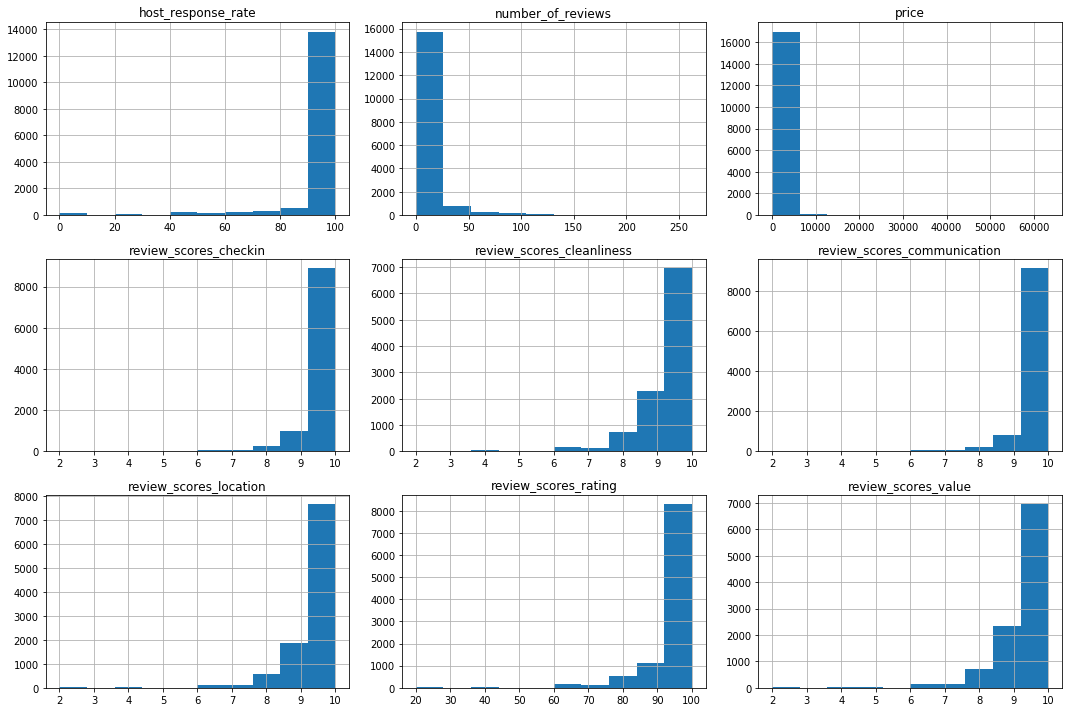

In [257]:
# Let's see their distribution
f, ax = plt.subplots(figsize=(15,10))
listings_en[cols].hist(ax=ax);
plt.tight_layout()

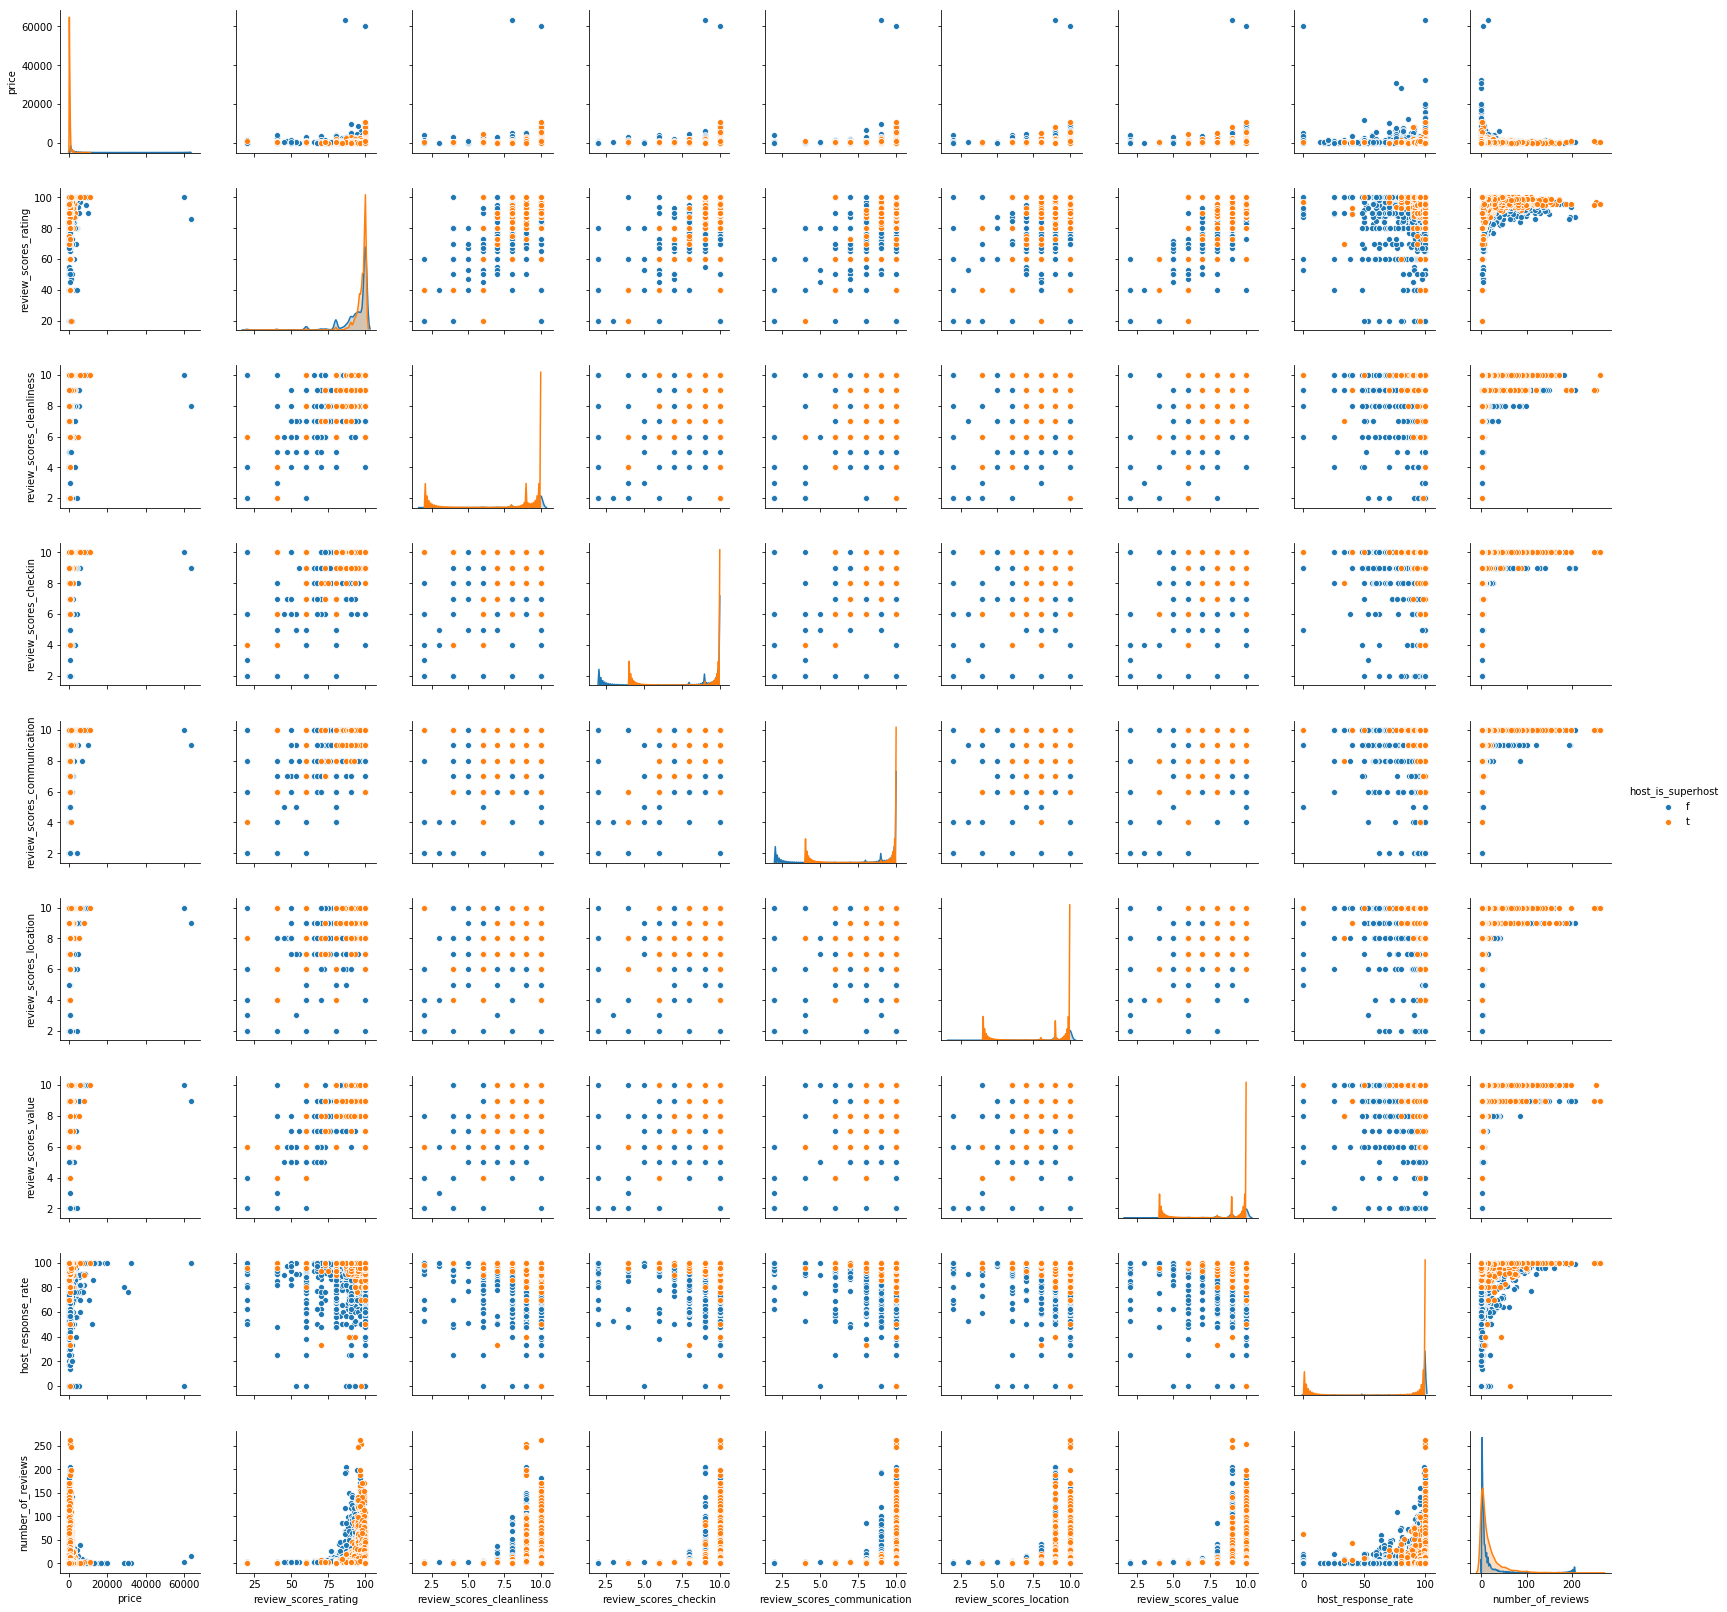

In [258]:
import seaborn as sns
sns.pairplot(listings_en[cols + ['host_is_superhost']], hue='host_is_superhost');

**Let's group them by neigbourhood_cleansed**

In [101]:
#groupby neighbourhood_cleansed, see the relationship of price and review_Scores
cols = ['price','review_scores_rating',
       'review_scores_cleanliness','review_scores_checkin','review_scores_communication', 'review_scores_location',
        'review_scores_value']
listings_nb = listings_en.groupby('neighbourhood_cleansed')[cols].mean().sort_values('price',ascending=False)
                                                 

#add pos_neg ratio from reviews_en_compileto listings_nb_clean df
pos_neg_ratio = [(nb,reviews_en_compile[nb]['pos_neg']) for nb in listings_en.neighbourhood_cleansed.unique()]
x, y = zip(*sorted(pos_neg_ratio, key=lambda x: x[1], reverse=True))
pos_neg_ratio_series = pd.Series( list(y), index=list(x),) 

#add to listings_nb_clean df
listings_nb['pos_neg_ratio'] = pos_neg_ratio_series
listings_nb

,price,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,pos_neg_ratio
neighbourhood_cleansed,,,,,,,,
Huairou,1645.137681,96.545455,9.673797,9.909091,9.882353,9.741935,9.435484,34.733333
Changping,1144.359948,95.357576,9.490909,9.717325,9.772036,9.255319,9.528875,43.727273
Shunyi,777.600462,95.697674,9.572093,9.841860,9.869767,9.288372,9.539535,24.714286
Dongcheng,657.974734,94.816799,9.496346,9.806825,9.823888,9.798171,9.506707,23.132588
Xicheng,506.198995,94.829630,9.528889,9.792593,9.842963,9.747774,9.510386,20.477876
Tongzhou,494.731001,94.708934,9.491379,9.717579,9.723343,8.930636,9.500000,35.300000
Daxing,491.688679,94.659498,9.451613,9.697842,9.752688,9.197842,9.456835,18.600000
Chaoyang,469.854459,94.620080,9.459078,9.750105,9.790869,9.615855,9.493674,27.833803
Haidian,442.815042,94.535984,9.455852,9.753941,9.808350,9.645161,9.452299,25.062500


Text(0.5,0,'pos_neg_ratio')

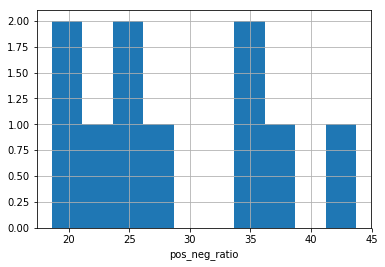

In [250]:
#distribution pos_neg ratio
listings_nb.pos_neg_ratio.hist()
plt.xlabel("pos_neg_ratio")

In [103]:
#standardize listings_nb_clean to its mean

for col in listings_nb.columns:
    if col == 'pos_neg_ratio':
        listings_nb['pos_neg_ratio_std'] = ( listings_nb['pos_neg_ratio'] - listings_nb['pos_neg_ratio'].mean() )/ listings_nb['pos_neg_ratio'].std()
    else:
        listings_nb[col+"_std"] = (listings_nb[col] - listings_en[col].mean() ) / listings_en[col].std()
    

### 4.1. QUESTION 1 - Where is the most value neighbourhood ? <a name="question_1"></a>

This is to answer the first question in problem understanding

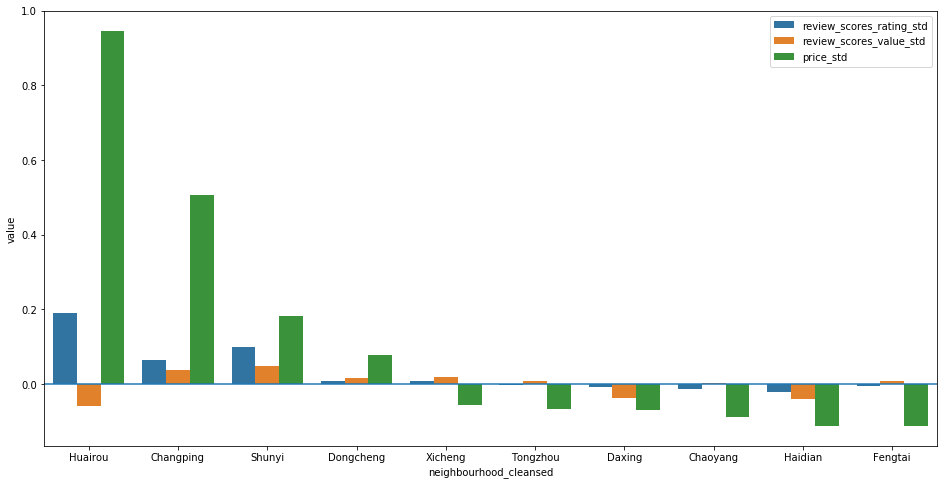

In [35]:
"""Sort by Price"""

data = listings_nb.sort_values('price_std', ascending=False)
data = data[['review_scores_rating_std','review_scores_value_std', 'price_std']].stack().reset_index()
data.columns =[ 'neighbourhood_cleansed', 'type', 'value']

f, ax1 = plt.subplots(figsize=(16,8))

sns.barplot('neighbourhood_cleansed','value', hue='type', data=data, ax=ax1)

plt.legend()
ax1.axhline(0)


Here you can see descending order of standardized listing `price` per day along with standardized of overall experience (`review_scores_rating`) and value (`review_scores_value`). `Huairou` district is overpriced as it is the highest price in Beijing but also the least value score. It is not surprising that the Great Wall is located in this district. The underprice neighbourhood would be `Xicheng`, `Tongzhou`, and `Fengtai` district as the price below average while value score is slightly above average. If you are not on budget, `Changping`, `Shunyi`, and `DongCheng` district would be good.

### 4.1. QUESTION 2 - Where is the most positive vibes neighbourhood ? <a name="question_2"></a>

This is to answer the second question in problem understanding

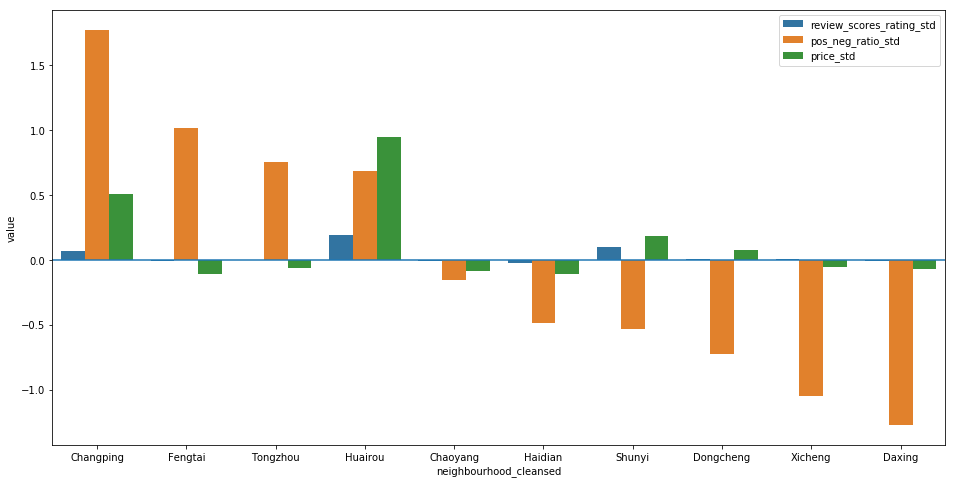

In [38]:
"""Sort by review_pos_neg_std"""

data = listings_nb.sort_values('pos_neg_ratio_std', ascending=False)
data = data[['review_scores_rating_std', 'pos_neg_ratio_std', 'price_std']].stack().reset_index()
data.columns =[ 'neighbourhood_cleansed', 'type', 'value']

f, ax1 = plt.subplots(figsize=(16,8))


sns.barplot('neighbourhood_cleansed', 'value', hue='type', data=data, ax=ax1)

plt.legend()
ax1.axhline(0)


Here you can see that the more positive vibes districts are `Changping`, `Fengtai`, `Tongzhou`, and `Huairou`. Now you can see, probably `Huairou` and `Changping` district are worth it given the higher price if you can afford it. Consistent with the previous graph, `Tongzhou` and `Fengtai` district are probably the most value district.

---
## 5. Data Preparation for modelling <a name="data_preparation"></a>

In [183]:
# I personally pick features to use

features_cols = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 
 'host_identity_verified','neighbourhood_cleansed','is_location_exact', 'property_type','room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
'bed_type', 'amenities', 'price', 'guests_included','has_availability', 'availability_30', 
'availability_60','availability_90', 'availability_365','number_of_reviews','review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
'review_scores_communication', 'review_scores_location', 'requires_license', 'instant_bookable',
'is_business_travel_ready', 'cancellation_policy','require_guest_profile_picture', 'require_guest_phone_verification',
'reviews_per_month']

#drop na in review_scores_value as they are the target
listings_en_ = listings_en.dropna(subset=['review_scores_value'])

#collect features and target
features = listings_en_[features_cols]
target = listings_en_['review_scores_value']


In [184]:
features.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,within an hour,100.0,f,12,t,f,Chaoyang,t,Serviced apartment,Entire home/apt,9,2.0,3.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",814.0,7,t,17,37,64,332,79,92.0,9.0,9.0,10.0,9.0,9.0,f,t,f,strict_14_with_grace_period,f,f,0.81
2,within a few hours,100.0,t,1,t,f,Dongcheng,f,House,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Doorman,B...",400.0,2,t,8,24,29,30,253,97.0,10.0,9.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,f,f,2.88
3,within an hour,100.0,f,4,t,f,Dongcheng,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",386.0,1,t,0,0,15,290,26,77.0,8.0,7.0,9.0,9.0,9.0,f,t,f,strict_14_with_grace_period,f,f,0.31
4,within an hour,100.0,f,4,t,f,Chaoyang,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",552.0,1,t,11,32,62,337,37,87.0,8.0,7.0,9.0,9.0,9.0,f,t,f,strict_14_with_grace_period,f,f,0.44
5,within an hour,100.0,f,8,t,f,Dongcheng,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",386.0,2,t,20,50,80,355,21,81.0,8.0,8.0,8.0,8.0,9.0,f,t,f,moderate,f,t,0.26


In [185]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10348 entries, 0 to 18693
Data columns (total 37 columns):
host_response_time                  9883 non-null object
host_response_rate                  9883 non-null float64
host_is_superhost                   10348 non-null object
host_listings_count                 10348 non-null int64
host_has_profile_pic                10348 non-null object
host_identity_verified              10348 non-null object
neighbourhood_cleansed              10348 non-null object
is_location_exact                   10348 non-null object
property_type                       10348 non-null object
room_type                           10348 non-null object
accommodates                        10348 non-null int64
bathrooms                           10345 non-null float64
bedrooms                            10348 non-null float64
beds                                10343 non-null float64
bed_type                            10348 non-null object
amenities            

### 5.1 Dealing with Ordinal features

In [186]:
#host_response_time

host_map = {'within an hour': 1,
           'within a few hours': 2,
           'within a day': 3,
           'a few days or more': 4}

features.host_response_time = features.host_response_time.replace(host_map)

#cancellation_policy

cancel_map = {'flexible' : 1,
             'moderate': 2,
             'strict_14_with_grace_period': 3}

features.cancellation_policy = features.cancellation_policy.replace(cancel_map)

### 5.2 Dealing with Binary features : 
Contains t (True) or f (False)

In [187]:
binary_features = [col for col in features.columns if features[col].isin(['t','f']).any()]
binary_features

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'is_location_exact',
 'has_availability',
 'requires_license',
 'instant_bookable',
 'is_business_travel_ready',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [188]:
def binary_features_encoding(string):
    """ t (true) = 1 and f (false = 0)"""
    if pd.isnull(string):
        return np.nan
    elif string == 't':
        return 1
    else:
        return 0
        

In [189]:
for bin_feature in binary_features:
    features[bin_feature] = features[bin_feature].apply(binary_features_encoding)

In [190]:
features[binary_features].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,has_availability,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification
0,0,1,0,1,1,0,1,0,0,0
2,1,1,0,0,1,0,0,0,0,0
3,0,1,0,1,1,0,1,0,0,0
4,0,1,0,1,1,0,1,0,0,0
5,0,1,0,1,1,0,1,0,0,1


### 5.3 Encoding amenities

In [191]:
#counting how many amenities provided 
features['len_amenities'] = features.amenities.apply(lambda x: len(x.strip('{}').replace('"',"").split(",")) if not pd.isnull(x) else np.nan)

#drop amenities column
features = features.drop('amenities', axis=1) 

In [192]:
features.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,len_amenities
0,1.0,100.0,0,12,1,0,Chaoyang,1,Serviced apartment,Entire home/apt,9,2.0,3.0,4.0,Real Bed,814.0,7,1,17,37,64,332,79,92.0,9.0,9.0,10.0,9.0,9.0,0,1,0,3,0,0,0.81,34
2,2.0,100.0,1,1,1,0,Dongcheng,0,House,Entire home/apt,3,1.0,1.0,1.0,Real Bed,400.0,2,1,8,24,29,30,253,97.0,10.0,9.0,10.0,10.0,10.0,0,0,0,3,0,0,2.88,10
3,1.0,100.0,0,4,1,0,Dongcheng,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,386.0,1,1,0,0,15,290,26,77.0,8.0,7.0,9.0,9.0,9.0,0,1,0,3,0,0,0.31,21
4,1.0,100.0,0,4,1,0,Chaoyang,1,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,552.0,1,1,11,32,62,337,37,87.0,8.0,7.0,9.0,9.0,9.0,0,1,0,3,0,0,0.44,16
5,1.0,100.0,0,8,1,0,Dongcheng,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,386.0,2,1,20,50,80,355,21,81.0,8.0,8.0,8.0,8.0,9.0,0,1,0,2,0,1,0.26,17


### 5.4 Dealing with categorical features

In [193]:
features.select_dtypes([np.object]).head()

,neighbourhood_cleansed,property_type,room_type,bed_type
0,Chaoyang,Serviced apartment,Entire home/apt,Real Bed
2,Dongcheng,House,Entire home/apt,Real Bed
3,Dongcheng,Apartment,Entire home/apt,Real Bed
4,Chaoyang,Apartment,Entire home/apt,Real Bed
5,Dongcheng,Apartment,Entire home/apt,Real Bed


In [194]:
# perform one-hot
cat_features_cols = features.select_dtypes([np.object]).columns
features_one_hot = pd.get_dummies(features,columns= cat_features_cols, dummy_na=True)
features_one_hot.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,len_amenities,neighbourhood_cleansed_Changping,neighbourhood_cleansed_Chaoyang,neighbourhood_cleansed_Daxing,neighbourhood_cleansed_Dongcheng,neighbourhood_cleansed_Fengtai,neighbourhood_cleansed_Haidian,neighbourhood_cleansed_Huairou,neighbourhood_cleansed_Shunyi,neighbourhood_cleansed_Tongzhou,neighbourhood_cleansed_Xicheng,neighbourhood_cleansed_nan,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Hut,property_type_Igloo,property_type_Loft,property_type_Minsu (Taiwan),property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan
0,1.0,100.0,0,12,1,0,1,9,2.0,3.0,4.0,814.0,7,1,17,37,64,332,79,92.0,9.0,9.0,10.0,9.0,9.0,0,1,0,3,0,0,0.81,34,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,2.0,100.0,1,1,1,0,0,3,1.0,1.0,1.0,400.0,2,1,8,24,29,30,253,97.0,10.0,9.0,10.0,10.0,10.0,0,0,0,3,0,0,2.88,10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1.0,100.0,0,4,1,0,1,2,1.0,1.0,1.0,386.0,1,1,0,0,15,290,26,77.0,8.0,7.0,9.0,9.0,9.0,0,1,0,3,0,0,0.31,21,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1.0,100.0,0,4,1,0,1,4,1.0,1.0,2.0,552.0,1,1,11,32,62,337,37,87.0,8.0,7.0,9.0,9.0,9.0,0,1,0,3,0,0,0.44,16,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,1.0,100.0,0,8,1,0,1,2,1.0,1.0,1.0,386.0,2,1,20,50,80,355,21,81.0,8.0,8.0,8.0,8.0,9.0,0,1,0,2,0,1,0.26,17,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [195]:
features_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10348 entries, 0 to 18693
Data columns (total 89 columns):
host_response_time                  9883 non-null float64
host_response_rate                  9883 non-null float64
host_is_superhost                   10348 non-null int64
host_listings_count                 10348 non-null int64
host_has_profile_pic                10348 non-null int64
host_identity_verified              10348 non-null int64
is_location_exact                   10348 non-null int64
accommodates                        10348 non-null int64
bathrooms                           10345 non-null float64
bedrooms                            10348 non-null float64
beds                                10343 non-null float64
price                               10348 non-null float64
guests_included                     10348 non-null int64
has_availability                    10348 non-null int64
availability_30                     10348 non-null int64
availability_60           

### 5.5 Dealing with missing value

In [196]:
features_one_hot.isnull().sum().sort_values(ascending=False)

host_response_time                  465
host_response_rate                  465
review_scores_rating                  9
beds                                  5
bathrooms                             3
len_amenities                         0
requires_license                      0
instant_bookable                      0
is_business_travel_ready              0
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
reviews_per_month                     0
neighbourhood_cleansed_Chaoyang       0
neighbourhood_cleansed_Changping      0
review_scores_communication           0
neighbourhood_cleansed_Daxing         0
neighbourhood_cleansed_Dongcheng      0
neighbourhood_cleansed_Fengtai        0
neighbourhood_cleansed_Haidian        0
neighbourhood_cleansed_Huairou        0
neighbourhood_cleansed_Shunyi         0
neighbourhood_cleansed_Tongzhou       0
review_scores_location                0
review_scores_cleanliness             0


#### 5.5.1 Marking missing values before imputing

In [198]:
missing_cols = features_one_hot.columns[features_one_hot.isnull().sum() > 0]
for col in missing_cols:
    features_one_hot[col + "_na"] = features_one_hot[col].isnull() * 1


In [199]:
features_one_hot.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,len_amenities,neighbourhood_cleansed_Changping,neighbourhood_cleansed_Chaoyang,neighbourhood_cleansed_Daxing,neighbourhood_cleansed_Dongcheng,neighbourhood_cleansed_Fengtai,neighbourhood_cleansed_Haidian,neighbourhood_cleansed_Huairou,neighbourhood_cleansed_Shunyi,neighbourhood_cleansed_Tongzhou,neighbourhood_cleansed_Xicheng,neighbourhood_cleansed_nan,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Hut,property_type_Igloo,property_type_Loft,property_type_Minsu (Taiwan),property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,host_response_time_na,host_response_rate_na,bathrooms_na,beds_na,review_scores_rating_na
0,1.0,100.0,0,12,1,0,1,9,2.0,3.0,4.0,814.0,7,1,17,37,64,332,79,92.0,9.0,9.0,10.0,9.0,9.0,0,1,0,3,0,0,0.81,34,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2.0,100.0,1,1,1,0,0,3,1.0,1.0,1.0,400.0,2,1,8,24,29,30,253,97.0,10.0,9.0,10.0,10.0,10.0,0,0,0,3,0,0,2.88,10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1.0,100.0,0,4,1,0,1,2,1.0,1.0,1.0,386.0,1,1,0,0,15,290,26,77.0,8.0,7.0,9.0,9.0,9.0,0,1,0,3,0,0,0.31,21,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,100.0,0,4,1,0,1,4,1.0,1.0,2.0,552.0,1,1,11,32,62,337,37,87.0,8.0,7.0,9.0,9.0,9.0,0,1,0,3,0,0,0.44,16,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,1.0,100.0,0,8,1,0,1,2,1.0,1.0,1.0,386.0,2,1,20,50,80,355,21,81.0,8.0,8.0,8.0,8.0,9.0,0,1,0,2,0,1,0.26,17,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### 5.5.2 Imputing missing values

In [200]:
from sklearn.preprocessing import Imputer

imp = Imputer()
imp.fit(features_one_hot)

features_imp = pd.DataFrame(imp.transform(features_one_hot), index= features_one_hot.index, columns=features_one_hot.columns)


In [201]:
features_imp.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,len_amenities,neighbourhood_cleansed_Changping,neighbourhood_cleansed_Chaoyang,neighbourhood_cleansed_Daxing,neighbourhood_cleansed_Dongcheng,neighbourhood_cleansed_Fengtai,neighbourhood_cleansed_Haidian,neighbourhood_cleansed_Huairou,neighbourhood_cleansed_Shunyi,neighbourhood_cleansed_Tongzhou,neighbourhood_cleansed_Xicheng,neighbourhood_cleansed_nan,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Hut,property_type_Igloo,property_type_Loft,property_type_Minsu (Taiwan),property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,host_response_time_na,host_response_rate_na,bathrooms_na,beds_na,review_scores_rating_na
0,1.0,100.0,0.0,12.0,1.0,0.0,1.0,9.0,2.0,3.0,4.0,814.0,7.0,1.0,17.0,37.0,64.0,332.0,79.0,92.0,9.0,9.0,10.0,9.0,9.0,0.0,1.0,0.0,3.0,0.0,0.0,0.81,34.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,100.0,1.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,400.0,2.0,1.0,8.0,24.0,29.0,30.0,253.0,97.0,10.0,9.0,10.0,10.0,10.0,0.0,0.0,0.0,3.0,0.0,0.0,2.88,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,100.0,0.0,4.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,386.0,1.0,1.0,0.0,0.0,15.0,290.0,26.0,77.0,8.0,7.0,9.0,9.0,9.0,0.0,1.0,0.0,3.0,0.0,0.0,0.31,21.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,100.0,0.0,4.0,1.0,0.0,1.0,4.0,1.0,1.0,2.0,552.0,1.0,1.0,11.0,32.0,62.0,337.0,37.0,87.0,8.0,7.0,9.0,9.0,9.0,0.0,1.0,0.0,3.0,0.0,0.0,0.44,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,100.0,0.0,8.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,386.0,2.0,1.0,20.0,50.0,80.0,355.0,21.0,81.0,8.0,8.0,8.0,8.0,9.0,0.0,1.0,0.0,2.0,0.0,1.0,0.26,17.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
#make sure no missing values
features_imp.isnull().sum().sum()

0

### 5.6 Split Data : Train and Test

In [204]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(features_imp, target, test_size=0.33, random_state=42)

### 5.6 Create a function for data preparation

In [229]:
def features_processing(df, target_col, features_cols):
    """ 
    This function accept dataframe, target_col name, and features_cols list.
    It performs data preparation for machine learning modeling:
        - Remove missing value of target, and creating features and target
        - Counting Amenities, count how many amenities offere, then drop amenities column 
        - Dealing with ordinal features
        - Dealing with binary features
        - Dealing with categorical features : One hot encoding
        - Dealing with missing values
        - Data split: train and test
    
    Return : X_train, X_test, y_train, y_test
    
    """
    
    """remove missing value of target, and creating features and target,"""
    df = df.dropna(subset=[target_col])
    features = df[features_cols]
    target = df[target_col]
    
    """ Counting Amenities : count how many amenities offere, then drop amenities column """

    features['len_amenities'] = features.amenities.apply(lambda x: len(x.strip('{}').replace('"',"").split(",")) if not pd.isnull(x) else np.nan)
    features = features.drop('amenities', axis=1)    
    
    """Dealing with ordinal features"""
    
    #host_response_time

    host_map = {'within an hour': 1,
               'within a few hours': 2,
               'within a day': 3,
               'a few days or more': 4}

    features.host_response_time = features.host_response_time.replace(host_map)

    #cancellation_policy

    cancel_map = {'flexible' : 1,
                 'moderate': 2,
                 'strict_14_with_grace_period': 3}

    features.cancellation_policy = features.cancellation_policy.replace(cancel_map)
    
    """ Dealing with binary features"""
    
    binary_features = [col for col in features.columns if features[col].isin(['t','f']).any()]
    
    for bin_feature in binary_features:
        features[bin_feature] = features[bin_feature].apply(binary_features_encoding)
    
    """ Dealing with categorical features : One hot encoding """
    #onehot
    features_onehot = get_onehot(features)
    
    """ Dealing with missing values"""
    
    #marking row with missing value that will be imputed 
    features_marking_na = marking_na(features_onehot)
    
    #imputing
    features_imp = imputing(features_marking_na)
    
    """ split train test """
    X_train, X_test, y_train, y_test = get_train_test(features_imp, target)
    
    return X_train, X_test, y_train, y_test

def binary_features_encoding(string):
    """ t (true) = 1 and f (false = 0)"""
    if pd.isnull(string):
        return np.nan
    elif string == 't':
        return 1
    else:
        return 0
        

def get_onehot(features):
   
    """ One-hot categorical features"""
    cat_features = features.select_dtypes(include=[object])
    cat_features_cols = cat_features.columns
    features_onehot = pd.get_dummies(features,columns= cat_features_cols, dummy_na=True)
    
    """ Process Ordinal features : ['host_response_time', 'cancellation_policy']  """
    
    return features_onehot

def get_train_test(features, target):
    
    """ Split : Train - Test """

    from sklearn.model_selection import train_test_split as tts

    X_train, X_test, y_train, y_test = tts(features, target, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

def marking_na(features):
    """
    Creating Dummy NA columns for missing value in each features 
    """

    missing_cols = features.columns[features.isnull().sum() > 0]
    for col in missing_cols:
        features[col + "_na"] = features[col].isnull() * 1
   
    return features

def imputing(features):
    """ Impute Missing Data """
    from sklearn.preprocessing import Imputer

    imp = Imputer()
    imp.fit(X_train)

    features_imp = pd.DataFrame(imp.transform(features), index= features.index, columns=features.columns)
    
    return features_imp



In [230]:
X_train2, X_test2, y_train2, y_test2 = features_processing(listings_en, 'review_scores_value', features_cols)

---
## 6. Machine Learning Modeling <a name="modelling"></a>



### 6.1 Base Model

In [344]:
""" BASE MODEL & ALL FEATURES using AdaBoost Classifier """

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import  mean_squared_error

model = AdaBoostRegressor(random_state=1)
model.fit(X_train, y_train)
print('score : ', model.score(X_test, y_test))
print('mse : ', mean_squared_error(y_test, model.predict(X_test)))


score :  0.2873922793769238
mse :  0.614799908057651


In [291]:
""" Model Tuning """

# Import 'GridSearchCV'
from sklearn.model_selection import GridSearchCV


# Initialize the classifier

clf = AdaBoostRegressor(random_state=1)

#Create the parameters list to tune

parameters = {'n_estimators':[25,50,75], 
              'learning_rate':[0.1,0.5, 1.],
              
             }


# Perform grid search 
grid_obj = GridSearchCV(clf, param_grid=parameters,scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

# Fit the grid search object to the training data 
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_



Fitting 3 folds for each of 9 candidates, totalling 27 fits


[CV] learning_rate=0.1, n_estimators=25 ..............................
[CV] learning_rate=0.1, n_estimators=25 ..............................
[CV] learning_rate=0.1, n_estimators=25 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV]  learning_rate=0.1, n_estimators=25, score=-0.3583947415372443, total=   1.7s
[CV]  learning_rate=0.1, n_estimators=25, score=-0.360256772968901, total=   1.6s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV]  learning_rate=0.1, n_estimators=25, score=-0.3249669521289459, total=   1.7s
[CV] learning_rate=0.1, n_estimators=75 ..............................
[CV]  learning_rate=0.1, n_estimators=50, score=-0.3816280203939612, total=   3.0s
[CV] learning_rate=0.1, n_estimators=75 ..............................
[CV]  learning_rate=0.1, n_estimators=50, score=-0.35850692928486766, total=   3.3s
[CV] learning_rat

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.3s


[CV]  learning_rate=0.1, n_estimators=75, score=-0.39985712954013014, total=   5.0s
[CV] learning_rate=0.5, n_estimators=25 ..............................
[CV]  learning_rate=0.5, n_estimators=25, score=-0.43014514099009676, total=   1.9s
[CV] learning_rate=0.5, n_estimators=25 ..............................
[CV]  learning_rate=0.1, n_estimators=75, score=-0.4020242699309617, total=   5.4s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=25, score=-0.4739104167389028, total=   1.9s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=25, score=-0.49358026533024174, total=   1.8s
[CV] learning_rate=0.5, n_estimators=50 ..............................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.2s


[CV]  learning_rate=0.1, n_estimators=75, score=-0.3826520430399261, total=   5.5s
[CV] learning_rate=0.5, n_estimators=75 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=-0.590426083410309, total=   3.3s
[CV] learning_rate=0.5, n_estimators=75 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=-0.7670812774099216, total=   3.3s
[CV] learning_rate=0.5, n_estimators=75 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=-0.7338153071559643, total=   3.4s
[CV] learning_rate=1.0, n_estimators=25 ..............................
[CV]  learning_rate=1.0, n_estimators=25, score=-0.5335615329239018, total=   1.5s
[CV] learning_rate=1.0, n_estimators=25 ..............................
[CV]  learning_rate=0.5, n_estimators=75, score=-0.7415110844800935, total=   4.3s
[CV] learning_rate=1.0, n_estimators=25 ..............................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.5s


[CV]  learning_rate=1.0, n_estimators=25, score=-0.7507454076793926, total=   1.4s
[CV] learning_rate=1.0, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=75, score=-0.9851600936685702, total=   4.5s
[CV] learning_rate=1.0, n_estimators=50 ..............................
[CV]  learning_rate=1.0, n_estimators=25, score=-0.7689043880704428, total=   1.5s
[CV] learning_rate=1.0, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=75, score=-0.9944324811822988, total=   4.4s
[CV] learning_rate=1.0, n_estimators=75 ..............................
[CV]  learning_rate=1.0, n_estimators=50, score=-0.8306567335760635, total=   2.8s
[CV] learning_rate=1.0, n_estimators=75 ..............................
[CV]  learning_rate=1.0, n_estimators=50, score=-1.0196761039276137, total=   2.6s
[CV] learning_rate=1.0, n_estimators=75 ..............................


[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:   19.8s remaining:    3.4s


[CV]  learning_rate=1.0, n_estimators=50, score=-1.4253741445721702, total=   2.8s
[CV]  learning_rate=1.0, n_estimators=75, score=-1.0196761039276137, total=   2.1s
[CV]  learning_rate=1.0, n_estimators=75, score=-0.9946012197417293, total=   3.7s
[CV]  learning_rate=1.0, n_estimators=75, score=-1.5523207845997935, total=   1.8s


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   21.6s finished


In [292]:
# Make predictions using the unoptimized and model
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)


# Report the before-and-afterscores

print("Unoptimized model\n------")
print("R2 score on testing data: {:.4f}".format(clf.score(X_test, y_test)))
print("MSE on testing data: {:.4f}".format(mean_squared_error(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final R2 score on the testing data: {:.4f}".format(best_clf.score(X_test, y_test)))
print("Final MSE score on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))


Unoptimized model
------
R2 score on testing data: 0.2874
MSE on testing data: 0.6148

Optimized Model
------
Final R2 score on the testing data: 0.6200
Final MSE score on the testing data: 0.3279


In [333]:
""" Feature Permutation Importance """
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.8609 ± 0.0182,review_scores_rating
0.0320 ± 0.0039,review_scores_accuracy
0.0226 ± 0.0017,review_scores_cleanliness
0.0077 ± 0.0007,review_scores_location
0.0037 ± 0.0006,review_scores_checkin
0.0006 ± 0.0002,review_scores_communication
0.0003 ± 0.0003,price
0.0003 ± 0.0004,availability_365
0.0000 ± 0.0002,property_type_Villa
0 ± 0.0000,neighbourhood_cleansed_Mentougou


### 6.2 Machine Learning Modelling with Selected  Features based on its importances

In [240]:
# also include number_of_reviews to see the relationship

cols = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
'review_scores_location','review_scores_checkin','review_scores_communication',
'price','availability_365', 'number_of_reviews']

X_train_new, X_test_new = X_train[cols], X_test[cols]

In [352]:
# Import 'GridSearchCV'
from sklearn.model_selection import GridSearchCV


# TODO: Initialize model
clf_new = AdaBoostRegressor(random_state=1)

# Create the parameters list to tune.

parameters = {'n_estimators':[25,50,75], 
              'learning_rate':[0.1,0.5, 1.],       
             }

# Perform grid search 
grid_obj_new = GridSearchCV(clf_new, param_grid=parameters,scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

# Fit the grid search object 
grid_fit_new = grid_obj_new.fit(X_train_new, y_train)

# Get the estimator
best_clf_new = grid_fit_new.best_estimator_



Fitting 3 folds for each of 9 candidates, totalling 27 fits


[CV] learning_rate=0.1, n_estimators=25 ..............................


[CV] learning_rate=0.1, n_estimators=25 ..............................
[CV] learning_rate=0.1, n_estimators=25 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV]  learning_rate=0.1, n_estimators=25, score=-0.3601375420051035, total=   0.5s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV]  learning_rate=0.1, n_estimators=25, score=-0.3451742270171638, total=   0.6s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV]  learning_rate=0.1, n_estimators=25, score=-0.32366955892150673, total=   0.5s
[CV] learning_rate=0.1, n_estimators=75 ..............................
[CV]  learning_rate=0.1, n_estimators=50, score=-0.3748043794582637, total=   0.8s
[CV] learning_rate=0.1, n_estimators=75 ..............................
[CV]  learning_rate=0.1, n_estimators=50, score=-0.368236464614254, total=   0.8s
[CV] learning_rate=0.1, n_estimators=75 ..............................
[CV]  learning_ra

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV]  learning_rate=0.5, n_estimators=25, score=-0.5009178862608434, total=   0.4s
[CV] learning_rate=0.5, n_estimators=25 ..............................
[CV]  learning_rate=0.1, n_estimators=75, score=-0.3859723783255234, total=   1.1s
[CV] learning_rate=0.5, n_estimators=25 ..............................
[CV]  learning_rate=0.5, n_estimators=25, score=-0.49685243931288453, total=   0.5s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=25, score=-0.4979288212420695, total=   0.4s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV]  learning_rate=0.1, n_estimators=75, score=-0.4074877743127104, total=   1.2s
[CV] learning_rate=0.5, n_estimators=50 ..............................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV]  learning_rate=0.1, n_estimators=75, score=-0.40119199620306356, total=   1.3s
[CV] learning_rate=0.5, n_estimators=75 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=-0.6629780379865283, total=   0.5s
[CV] learning_rate=0.5, n_estimators=75 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=-0.6457379672159624, total=   0.7s
[CV] learning_rate=0.5, n_estimators=75 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=-0.617870569809094, total=   0.8s
[CV] learning_rate=1.0, n_estimators=25 ..............................
[CV]  learning_rate=0.5, n_estimators=75, score=-0.6629780379865283, total=   0.6s
[CV] learning_rate=1.0, n_estimators=25 ..............................
[CV]  learning_rate=1.0, n_estimators=25, score=-0.5267653366317907, total=   0.4s
[CV] learning_rate=1.0, n_estimators=25 ..............................
[CV]  learning_rate=0.5, n_estimators=75, score=-0.6457379672159624, total= 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


[CV]  learning_rate=1.0, n_estimators=25, score=-0.622967399747776, total=   0.3s
[CV] learning_rate=1.0, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=75, score=-0.7052289430019154, total=   1.2s
[CV] learning_rate=1.0, n_estimators=50 ..............................
[CV]  learning_rate=1.0, n_estimators=25, score=-0.7622369578095659, total=   0.4s
[CV] learning_rate=1.0, n_estimators=75 ..............................
[CV]  learning_rate=1.0, n_estimators=50, score=-0.5267653366317907, total=   0.4s
[CV] learning_rate=1.0, n_estimators=75 ..............................
[CV]  learning_rate=1.0, n_estimators=50, score=-0.622967399747776, total=   0.4s
[CV] learning_rate=1.0, n_estimators=75 ..............................
[CV]  learning_rate=1.0, n_estimators=75, score=-0.5267653366317907, total=   0.3s
[CV]  learning_rate=1.0, n_estimators=75, score=-0.622967399747776, total=   0.3s
[CV]  learning_rate=1.0, n_estimators=50, score=-0.8743944154701986

[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:    4.5s remaining:    0.8s


[CV]  learning_rate=1.0, n_estimators=75, score=-0.8743944154701986, total=   0.3s


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.9s finished


In [353]:
# Make predictions using the unoptimized and model
clf_new.fit(X_train_new, y_train)
predictions_new = clf_new.predict(X_test_new)
best_predictions_new = best_clf_new.predict(X_test_new)


# Report the before-and-afterscores

print("Unoptimized model\n------")
print("R2 score on testing data: {:.4f}".format(clf_new.score(X_test_new, y_test)))
print("MSE on testing data: {:.4f}".format(mean_squared_error(y_test, predictions_new)))
print("\nOptimized Model\n------")
print("Final R2 score on the testing data: {:.4f}".format(best_clf_new.score(X_test_new, y_test)))
print("Final MSE score on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions_new)))


Unoptimized model
------
R2 score on testing data: 0.3042
MSE on testing data: 0.6003

Optimized Model
------
Final R2 score on the testing data: 0.6276
Final MSE score on the testing data: 0.3213


---
## 7. Evaluation  <a name="evaluation"></a>

### 7.1 Model performance  summary:

|     Metric     | Base Features | Selected Features |
| :------------: | :---------------: | :-------------: | 
| R2 |     0.6200              |   0.6276              |
| MSE       |      0.3279             |   0.3213      |


The performance of model using selected features is similar with using base features

### 7.2 QUESTION 3 - How to choose and evaluate listings for the most value for price ? <a name="question_3"></a>
This is to explore and answer the third questions

In [354]:
""" Selected Feature Permutaion Importance"""
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_clf_new, random_state=1).fit(X_test_new, y_test)
eli5.show_weights(perm, feature_names = X_test_new.columns.tolist())

Weight,Feature
0.8286 ± 0.0369,review_scores_rating
0.0373 ± 0.0056,review_scores_accuracy
0.0189 ± 0.0008,review_scores_cleanliness
0.0071 ± 0.0008,review_scores_location
0.0037 ± 0.0002,review_scores_checkin
0.0011 ± 0.0007,price
0.0011 ± 0.0002,review_scores_communication
0.0010 ± 0.0005,number_of_reviews
0.0005 ± 0.0003,availability_365


It is not surprising that `review_scores_rating` is the most important feature. However, I wonder how those feature affect prediction. Are the higher rating predict the higher value ? What about the price and number of reviews ?

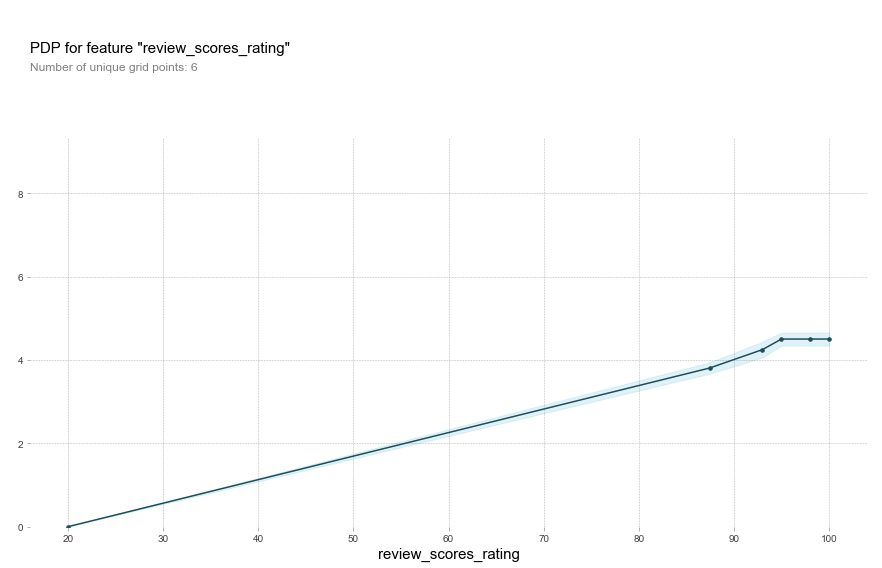

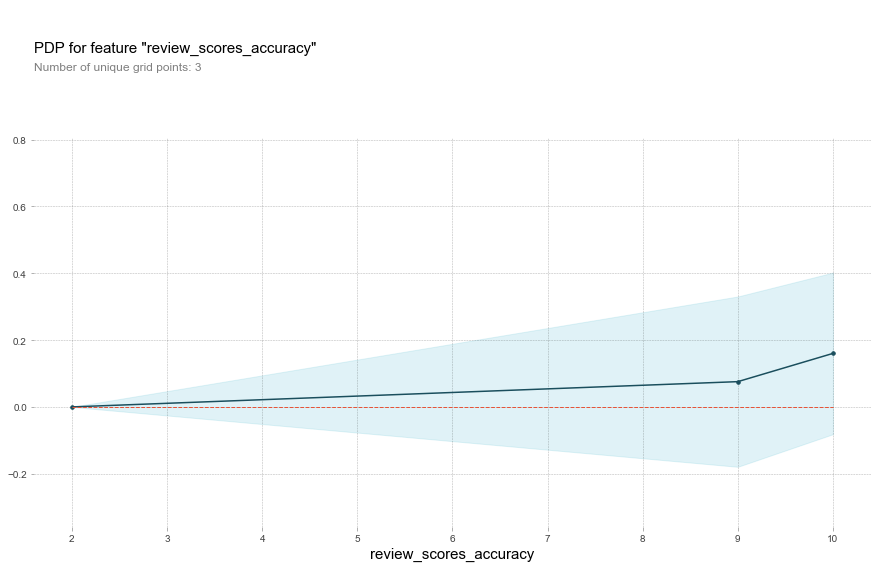

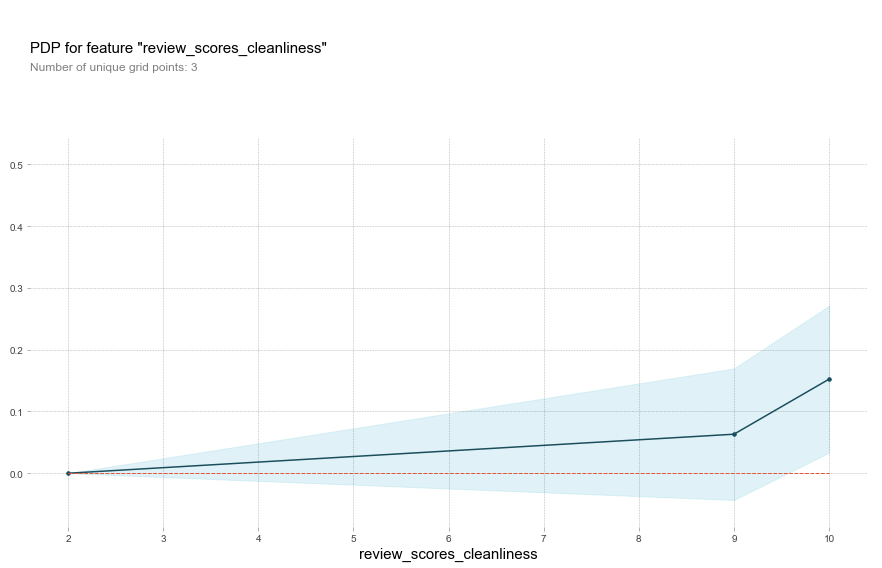

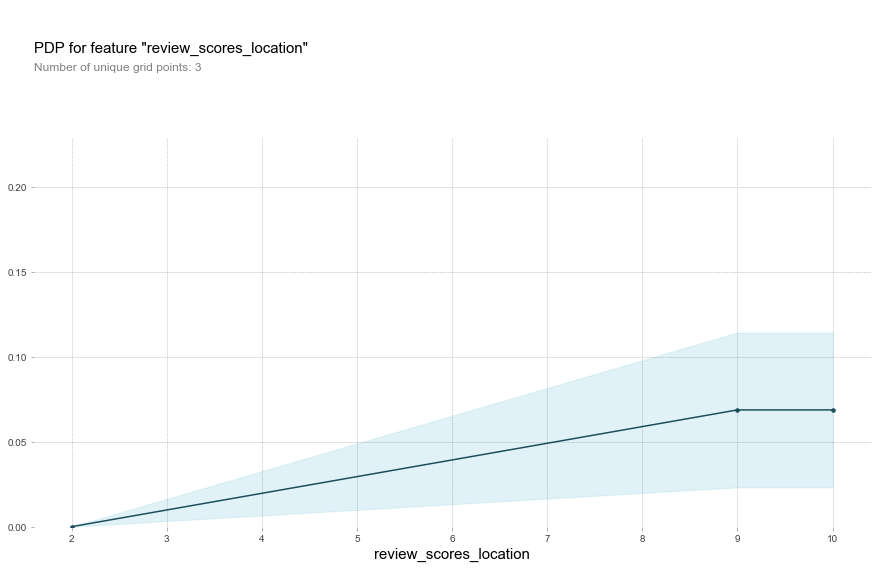

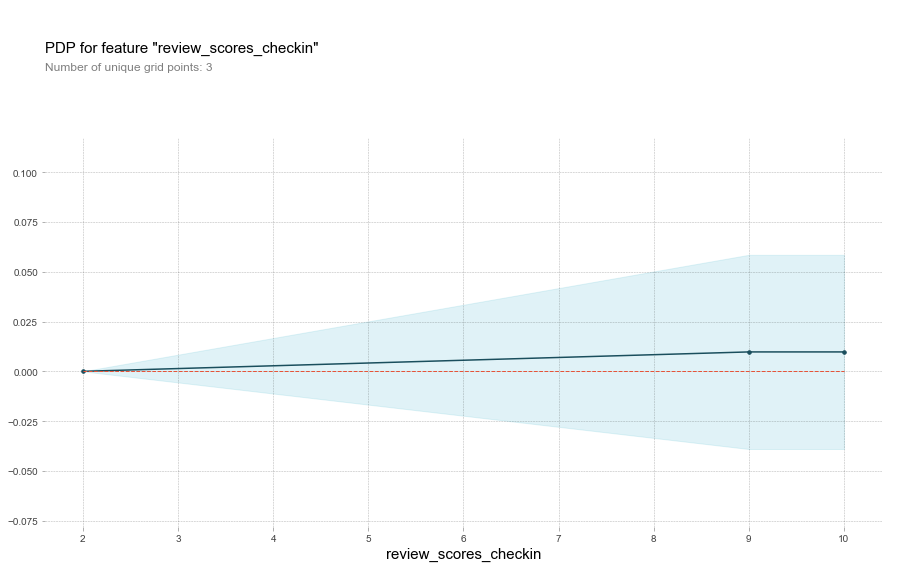

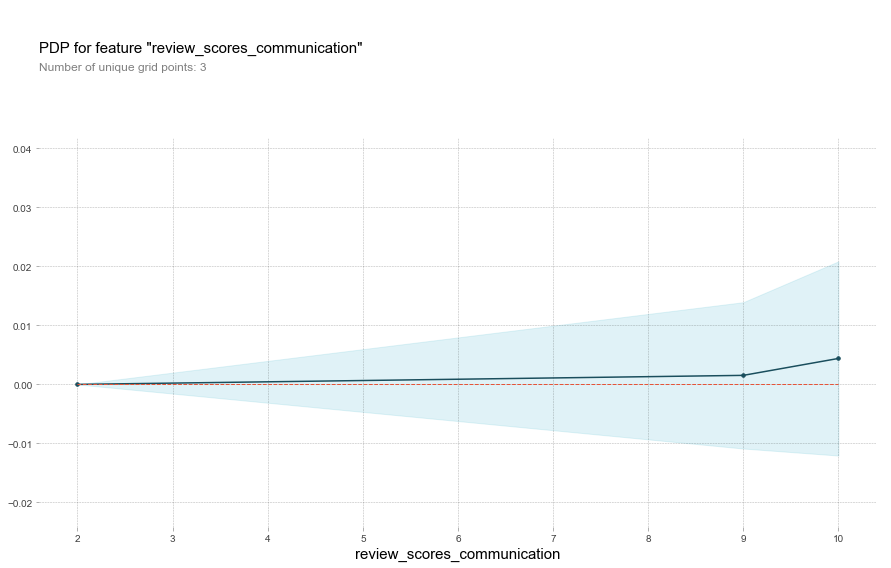

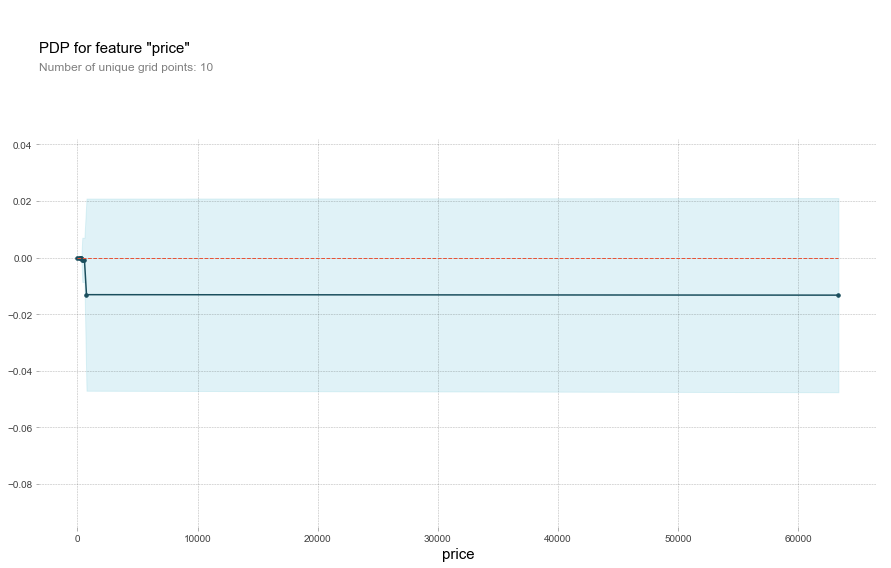

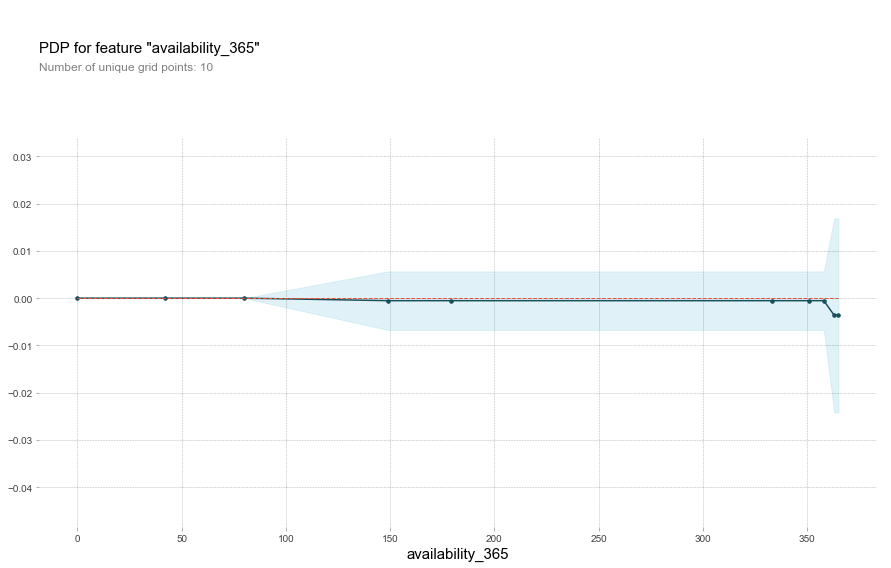

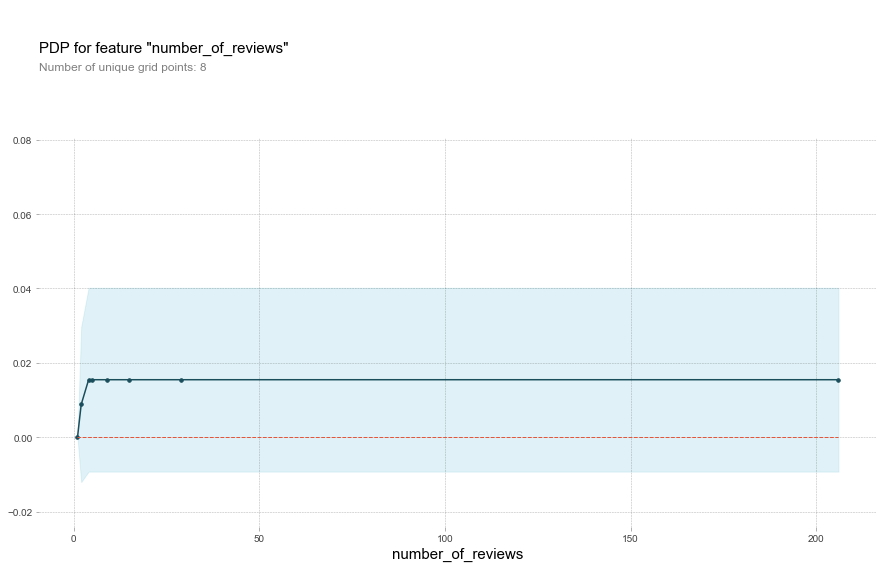

In [365]:
""" Partial Dependence Plot with pdpbox"""
from pdpbox import pdp, get_dataset, info_plots

for col in cols:
    
    feature_names = X_test_new.columns.tolist()
    feature=col
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=best_clf_new, dataset=X_test_new, model_features=feature_names, feature=feature)

    # plot it
    f, ax = pdp.pdp_plot(pdp_goals, feature)
    ax['pdp_ax'].set_xlabel(feature,size=15)
    
    # save it
    f.savefig("graph/best"+feature+".png", bbox_inches='tight')
    
    plt.show()

**Notes**:

1. 0.8286 ± 0.0369	review_scores_rating : the larger is better, but more than 95 did not added impact
2. 0.0373 ± 0.0056	review_scores_accuracy : at least 9 or higher
3. 0.0189 ± 0.0008	review_scores_cleanliness : at least 9 or higher
4. 0.0071 ± 0.0008	review_scores_location : the larger is better, but more than 9 did not added impact the prediction
5. 0.0037 ± 0.0002	review_scores_checkin : at leat 9 (but less impact), but more than 9 did not added impact
6. 0.0011 ± 0.0007	price : more than 300 start to varies, more than 570 reduce the value score
7. 0.0011 ± 0.0002	review_scores_communication : at least 9 (less impact)
8. 0.0010 ± 0.0005	number_of_reviews : min 4 reviews, more than 4 did not impact the prediction
9. 0.0005 ± 0.0003	availability_365 : start to vary 60 days, but no more than 365 days

The higher ther review scores rating substantially increases the chance that the listing is a great value for the price. However, scores rating beyond 95 (4.6) does not add the value of predictions. It is also appeared in review_scores_checkin and review_scores_location that scores beyond 9 (4.5). For other ratings such as cleanliness, accuracy, and communication, it is better to choose higher scores, at least 9 (4.5). As general, we should choose the higher scores, at least 4.5 stars, but 5 stars rating did not guarantee for best value for the price

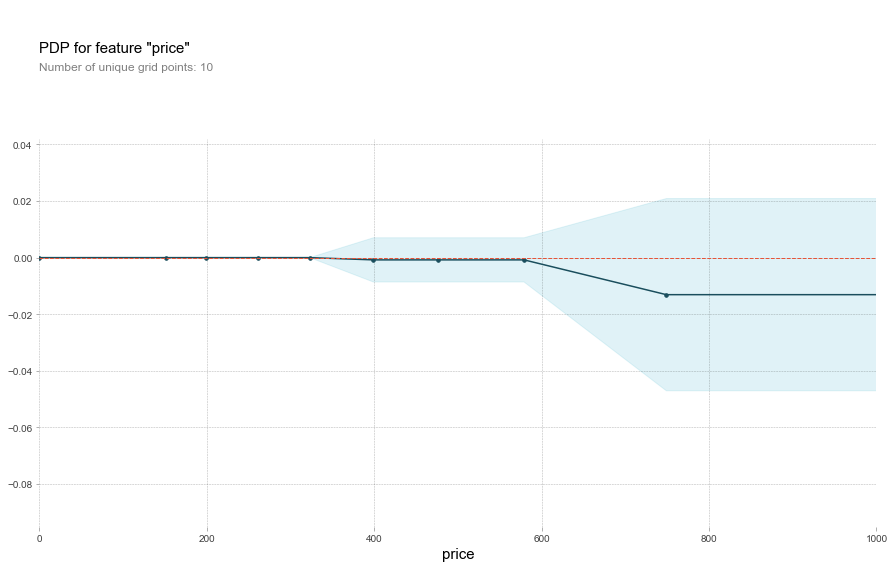

In [366]:
""" Look close on PRICE feature """
feature_names = X_test_new.columns.tolist()
feature='price'

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=best_clf_new, dataset=X_test_new, model_features=feature_names, feature=feature)

# plot it
f, ax = pdp.pdp_plot(pdp_goals, feature)
ax['pdp_ax'].set_xlabel(feature,size=15)
ax['pdp_ax'].set_xlim(0,1000)

# save it
f.savefig("graph/best"+feature+".png", bbox_inches='tight')

plt.show()

**What about the price ?** <a name="pdp_price"></a>

Based on this graph, the prices start to varies when the price is more than \\$300 and decreases the predictions when the price is more than \\$570. The higher the price, it probably may not value for the price. So, we should choose the lower price no more than \\$300 for sure.

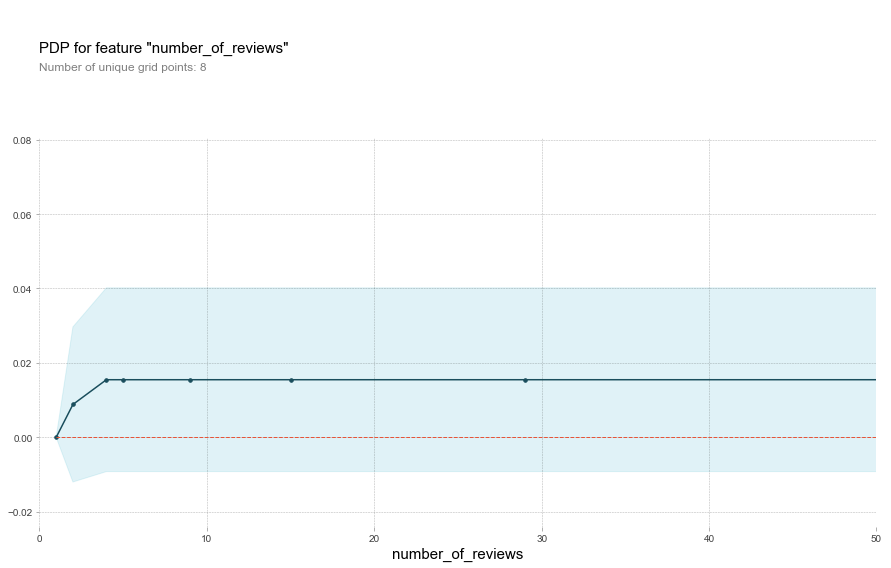

In [367]:
""" Look close on number_of_reviews feature """
feature_names = X_test_new.columns.tolist()
feature='number_of_reviews'

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=best_clf_new, dataset=X_test_new, model_features=feature_names, feature=feature)

# plot it
f, ax = pdp.pdp_plot(pdp_goals, feature)
ax['pdp_ax'].set_xlabel(feature,size=15)
ax['pdp_ax'].set_xlim(0,50)

# save it
f.savefig("graph/best"+feature+".png", bbox_inches='tight')

plt.show()

**How many reviews?** <a name="pdp_reviews" ></a>

Based on this graph, we see that increasing number of reviews increases the chances but have little impact when it is more than 4 reviews. So, Don't be a first one to try, we should choose and evaluate listing with at least 4 reviews.






---

## Conclusion <a name="conclusion"></a>

Lets take a look again at the three questions :

```
...finding the most value stay, specifically:

1. Where is the most value neighbourhood ?
2. Where is the most positive vibes neighbourhood ?
3. How to choose and evaluate listings for the most value for price ?
```

In this notebook, we took a look at which neighbourhood to stay and how to choose a great value listing according to AirBnB data from 2016 .

* We identify the most [overpriced neighbourhood](#question_1) is Huairou. The underpriced neighbourhood would be Xicheng, Tongzhou, and Fengtai district.
* We identify the more [positive vibes neighbourhoods](#question_2) are Changping, Fengtai, Tongzhou, and Huairou
* We noticed that a [full star rating](#question_3) does not guarantee for value review score, especially for overall review score rating and location review score.
* We need listings to have at least [4 reviews](#pdp_reviews) and no more than [$300 per day](#pdp_price) for higher chance of getting great value stay.